# Machine Learning experimental project
## Chihuahuas vs Muffins image classifier 
### Author: Wang Jing
#### Email: jing.wang4@studenti.unimi.it
#### Academic year: 2023/2024 


## Importing the libraries

In [233]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import activations, layers, optimizers, losses, regularizers
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow import random as tf_random
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2 # used to read and write images, resize image, convert images 
import os 
import random 
import pickle


In [157]:
# functions for the plots loss and accuracy

def performance_plot(history):
    step=int(len(history.history['loss'])/10)

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color = 'red')
    plt.plot(history.history['val_loss'], color = 'orange')
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)


    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))
    plt.yticks(np.arange(0, 1, step=0.1))

    plt.grid(alpha=.25)
    plt.legend(['Train', 'Val'])
    plt.title("Loss over epoch")

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color = 'red')
    plt.plot(history.history['val_accuracy'],color = 'orange')
    plt.ylabel('Accuracy', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['Train', 'Val'])
    plt.title("Accuracy over epoch")
    plt.grid(alpha=.25)
    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))
    plt.yticks(np.arange(0.3, 1, step=0.1))

    plt.show()



# set seed
def custom_seed_set():
    np.random.seed(123)
    tf.random.set_seed(123)

## Importing the data

In [159]:
path = '/Users/jingwang/Desktop/Machine Learning project/archive'

In [160]:
# Directory containing the images
train = '/Users/jingwang/Desktop/Machine Learning project/archive/train' # training set with the two categories
test = '/Users/jingwang/Desktop/Machine Learning project/archive/test' # test set with the two categories

# We have two categories
categories = ['chihuahua', 'muffin']  

# Loop through all files in the directory
for filename in os.listdir(train):
    # Check if the file is an image file 
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Construct the full path to the image file
        filepath = os.path.join(train, filename)
        
        # Load the image using OpenCV
        image = cv2.imread(filepath)
        
        # Check if the image was loaded successfully
        if image is not None:
            # Perform operations on the image as needed
            # For example, you can display the image, process it, etc.
            cv2.imshow('Image', image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        else:
            print(f"Error: Unable to load {filename}")

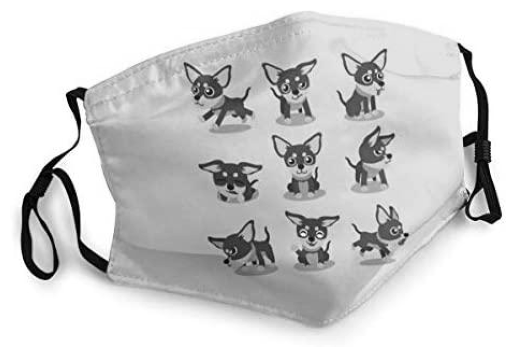

In [161]:
if categories:  # Check categories list is not empty
    first_category_path = os.path.join(train, categories[0])
    first_image_path = os.path.join(first_category_path, os.listdir(first_category_path)[0])
    img_array = cv2.imread(first_image_path, cv2.IMREAD_GRAYSCALE)
    
    if img_array is not None:
        plt.imshow(img_array, cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Unable to load {first_image_path}")
# plot the first image of the first category: Chihuahua


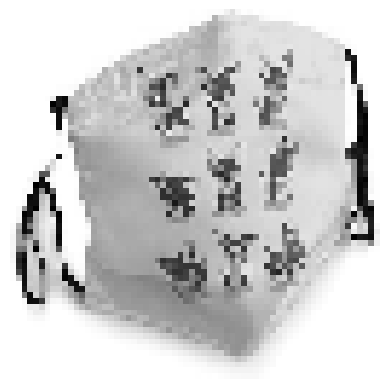

In [162]:
# resize the images, i decided to resize the images to 64 x 64
img_s = 64

new_array = cv2.resize(img_array, (img_s, img_s))
plt.imshow(new_array, cmap='gray')
plt.axis('off')
plt.show()

## Loading Images and Data Preprocessing


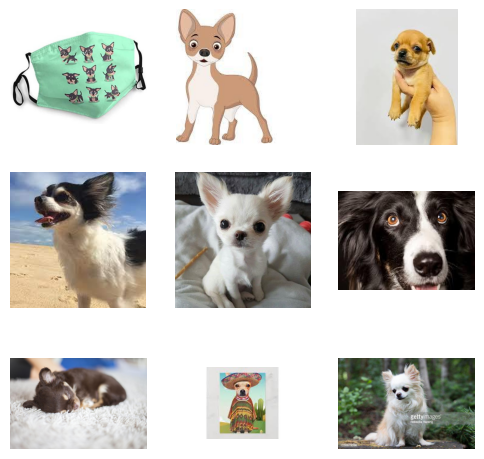

In [163]:
num_rows, num_cols = 3, 3

# Create a figure and axes object using plt.subplots
fig, axarr = plt.subplots(num_rows, num_cols, figsize=(6, 6))

# Define the directory containing the images
category_d = os.path.join(train, 'chihuahua')  # using the training set only for chihuahua.

# Iterate over each subplot position
for row in range(num_rows):
    for col in range(num_cols):
        # Calculate the index of the current image
        index = row * num_cols + col
        
        # Load the image from the directory
        img_filename = os.listdir(category_d)[index]
        img_path = os.path.join(category_d, img_filename)
        img_array = cv2.imread(img_path)

        
        axarr[row, col].imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        axarr[row, col].axis("off")

plt.show()

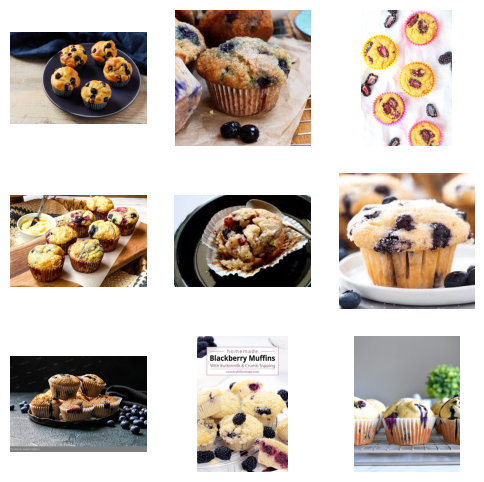

In [164]:
num_rows, num_cols = 3, 3

fig, axarr = plt.subplots(num_rows, num_cols, figsize=(6, 6))

category_d = os.path.join(train, 'muffin')   # using the training set only for muffin.

# Iterate over each subplot position
for row in range(num_rows):
    for col in range(num_cols):
        # Calculate the index of the current image
        index = row * num_cols + col
        
        # Load the image from the directory
        img_filename = os.listdir(category_d)[index]
        img_path = os.path.join(category_d, img_filename)
        img_array = cv2.imread(img_path)

        # Display the image on the subplot
        axarr[row, col].imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        axarr[row, col].axis("off")

# Display the plot
plt.show()

In [165]:
def create_data(data_type):
    data = []  # a list of data 
    base_path = '/Users/jingwang/Desktop/Machine Learning project/archive/' + data_type # path selected with the corresponding data type: train or test.
    
    for category in categories:
        path = os.path.join(base_path, category)
        class_num = categories.index(category) # here i have chihuahua index = 0 and muffin index = 1, binary encoding 
        
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_array is not None:
                resized_img = cv2.resize(img_array, (img_s, img_s)) 
                
                data.append([resized_img, class_num])
            else:
                print(f"Error: Unable to load {img_path}")
    
    return data

# Create training and test data
training_data = create_data("train")
test_data = create_data("test")

print("Number of training examples:", len(training_data))
print("Number of test examples:", len(test_data))

Number of training examples: 4733
Number of test examples: 1184


### All images will be represented as a 2D array of pixel values where each value corresponds to the intensity of a pixel.

In [166]:
print(training_data[:3])
# the image matrix is a 2D Numpy array where each value represents the intensity of a pixel.

[[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 0], [array([[254, 252, 249, ..., 255, 255, 255],
       [254, 254, 146, ..., 255, 255, 255],
       [252, 251, 154, ..., 255, 255, 255],
       ...,
       [121, 166, 159, ..., 255, 255, 255],
       [250, 174, 169, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 0], [array([[231, 231, 231, ..., 224, 224, 226],
       [229, 229, 229, ..., 224, 224, 224],
       [228, 228, 228, ..., 224, 224, 223],
       ...,
       [217, 217, 217, ..., 208, 189, 224],
       [217, 217, 217, ..., 201, 193, 224],
       [217, 217, 217, ..., 206, 196, 222]], dtype=uint8), 0]]


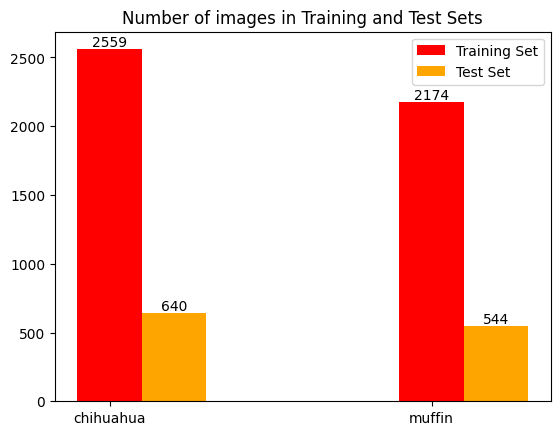

In [167]:
#the occurrences of each class in the training set
train_class_counts = [len([label for _, label in training_data if label == i]) for i in range(2)]

#  the occurrences of each class in the test set
test_class_counts = [len([label for _, label in test_data if label == i]) for i in range(2)]

# Plotting
bar_width = 0.20
fig, ax = plt.subplots()
train_bars = ax.bar(categories, train_class_counts, bar_width, label='Training Set', color= 'red')
test_bars = ax.bar([idx + bar_width for idx, label in enumerate(categories)], test_class_counts, bar_width, label='Test Set', color ='orange')

ax.set_title('Number of images in Training and Test Sets')
ax.legend()

# to add values on top of the bars
for bar, count in zip(train_bars, train_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

for bar, count in zip(test_bars, test_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.show()

### shuffling the data


In [168]:
random.shuffle(training_data)
random.shuffle(test_data)

In [169]:
# we got the labels shuffled so the data are also shuffled
for sample in training_data[2:5]:
    print(sample[1])
    print(sample[0])
# it is the matrix for each image after data shuffling

0
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
0
[[ 40  36  32 ...  27  31  39]
 [ 25  33  31 ...  28  33  31]
 [ 31  26  31 ...  38  18  28]
 ...
 [ 85  91 104 ...  52  49  45]
 [ 86 108  89 ...  52  50  68]
 [ 94 115  76 ...  52  51  55]]
1
[[ 36  18  32 ...  59  33  48]
 [ 48  51 140 ...  25  37  49]
 [ 36  41  34 ...  34  27  31]
 ...
 [ 57  66  62 ...  48  44  37]
 [ 61  64  69 ...  44  41  37]
 [ 65  68  68 ...  43  42  33]]


### data reshaping and data normalization

In [170]:
# Extracting features and labels for training data, reshapping data
X_train = np.array([features for features, label in training_data]).reshape(-1, img_s, img_s, 1)
y_train = np.array([label for features, label in training_data])

# Normalizing the pixel values for training data
X_train = X_train / 255.0

# Extracting features and labels for test data
X_test = np.array([features for features, label in test_data]).reshape(-1, img_s, img_s, 1)
y_test = np.array([label for features, label in test_data])

# Normalizing the pixel values for test data
X_test = X_test / 255.0

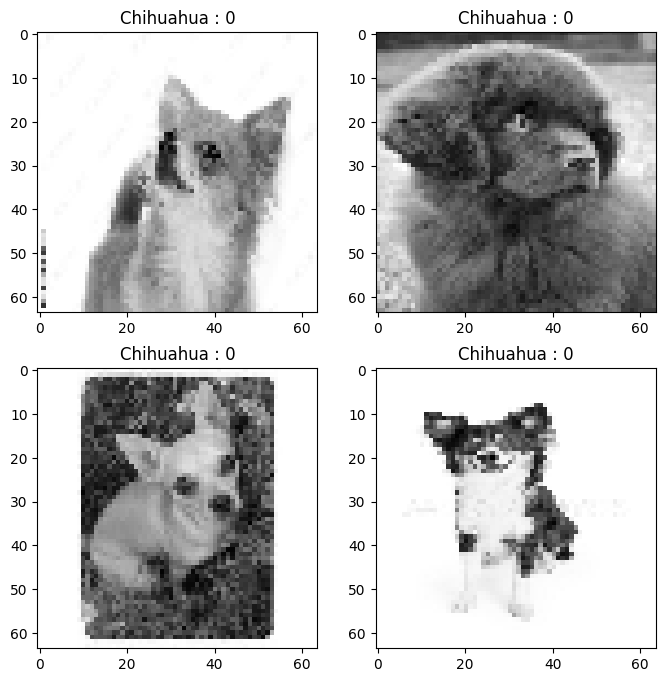

In [171]:
# random samples and labels from the training set
random_indices = random.sample(range(len(X_train)), 4) # it takes indexes randomly from all the training set 
random_samples = [X_train[i] for i in random_indices] # it takes the corresponding figures
labels = [y_train[i] for i in random_indices] # it takes the corresponding labels


fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        # image and label at the selected index
        image = random_samples[i * 2 + j]
        label = labels[i * 2 + j]  # binary labels
        
        # Plot the image
        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].axis('on')
        axes[i, j].set_title(f'Muffin : {label}' if label == 1 else f'Chihuahua : {label}')
plt.show()

In [172]:
folder_path = "NN data"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# data sets
datasets = {"X_train": X_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_train": y_train}

for i, j in datasets.items():
    pickle_path = os.path.join(folder_path, i + ".pickle")
    with open(pickle_path, "wb") as pickle_out:
        pickle.dump(j, pickle_out)

### Define a model
### First model: two convolutional layers, max pooling layer, flatten, a dense layer (as a first try)

In [173]:
custom_seed_set()
# Define a basic CNN for binary classification
basic_cnn = keras.Sequential([
    # First Convolutional Layer with MaxPooling
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # 64x64 grayscale images
    layers.MaxPooling2D((2, 2)),  # Downsampling by a factor of 2

    # Second Convolutional Layer with MaxPooling
    layers.Conv2D(32, (3, 3), activation='relu'),  # Increasing filter count
    layers.MaxPooling2D((2, 2)),  # Additional downsampling

    # Flattening and Dense Layer
    layers.Flatten(),  # Convert 2D feature maps into a 1D feature vector
    layers.Dense(64, activation='relu'),  # Fully connected layer for processing
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
basic_cnn.compile(
    optimizer='adam',  
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    metrics=['accuracy']  # Metric for model evaluation
)

# Example training with a simple split for validation
history_basic = basic_cnn.fit(
    X_train,  # Training data
    y_train,  # Training labels
    epochs=15,  # Number of epochs
    validation_split=0.1,  # Use 10% of the training data for validation
    batch_size=32  # Batch size
)

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5975 - loss: 0.6542 - val_accuracy: 0.7932 - val_loss: 0.4671
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7571 - loss: 0.5027 - val_accuracy: 0.8270 - val_loss: 0.4167
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8010 - loss: 0.4343 - val_accuracy: 0.8270 - val_loss: 0.3948
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8272 - loss: 0.3835 - val_accuracy: 0.8523 - val_loss: 0.3695
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8494 - loss: 0.3394 - val_accuracy: 0.8629 - val_loss: 0.3451
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8746 - loss: 0.2955 - val_accuracy: 0.8734 - val_loss: 0.3312
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8932 - loss: 0.2603 - val_accuracy: 0.8734 - val_loss: 0.3297
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9028 - loss: 0.2401 - val_accuracy: 0.869

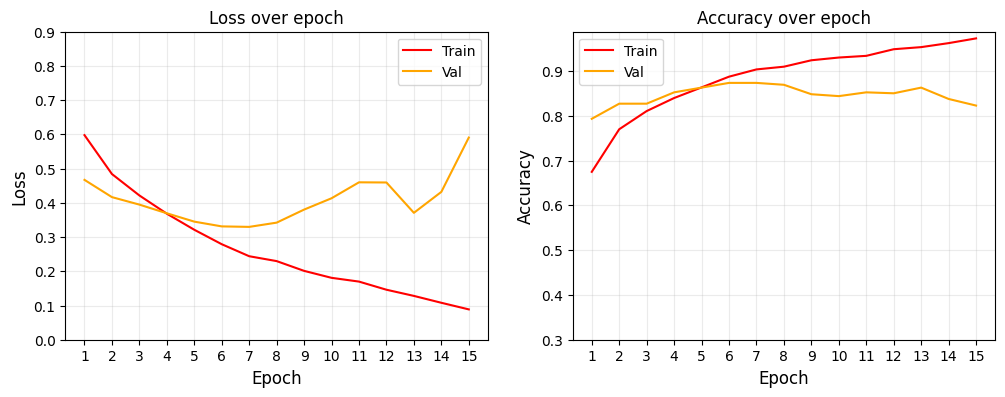

In [174]:
performance_plot(history_basic) # overfitting 

In [175]:
basic_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,013 (4.65 MB)

 Trainable params: 406,337 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 812,676 (3.10 MB)

### Another architecture with three convolutional layers 

In [176]:
custom_seed_set()
model2 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling
    layers.Flatten(),  # Flatten to transition to fully connected layers
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary - class classification
])


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)  # Adjust epochs/batch size as needed

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5735 - loss: 0.6569 - val_accuracy: 0.7595 - val_loss: 0.4921
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7568 - loss: 0.5157 - val_accuracy: 0.7764 - val_loss: 0.4623
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7902 - loss: 0.4585 - val_accuracy: 0.8207 - val_loss: 0.3961
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8203 - loss: 0.3998 - val_accuracy: 0.8586 - val_loss: 0.3672
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8462 - loss: 0.3674 - val_accuracy: 0.8608 - val_loss: 0.3493
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8616 - loss: 0.3316 - val_accuracy: 0.8671 - val_loss: 0.3348
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8814 - loss: 0.3055 - val_accuracy: 0.8544 - val_loss: 0.3366
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8937 - loss: 0.2670 - val_accuracy: 0.846

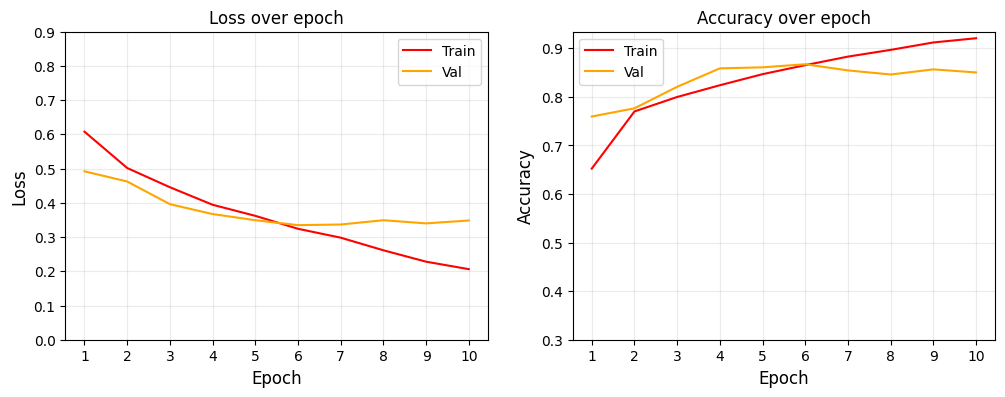

In [177]:
performance_plot(history2)  # it is better than the first model

In [178]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,949 (2.01 MB)

 Trainable params: 175,649 (686.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 351,300 (1.34 MB)

In [179]:
# with dropout 
model3 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling
    layers.Flatten(),  # Flatten to transition to fully connected layers
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary - class classification
])


model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)  # Adjust epochs/batch size as needed

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5767 - loss: 0.6640 - val_accuracy: 0.8017 - val_loss: 0.4680
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7185 - loss: 0.5708 - val_accuracy: 0.8122 - val_loss: 0.4545
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7742 - loss: 0.4947 - val_accuracy: 0.8291 - val_loss: 0.4008
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8035 - loss: 0.4574 - val_accuracy: 0.8544 - val_loss: 0.3701
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8188 - loss: 0.4196 - val_accuracy: 0.8586 - val_loss: 0.3443
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8348 - loss: 0.3857 - val_accuracy: 0.8734 - val_loss: 0.3182
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8588 - loss: 0.3426 - val_accuracy: 0.8755 - val_loss: 0.3091
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8661 - loss: 0.3115 - val_accuracy: 0.867

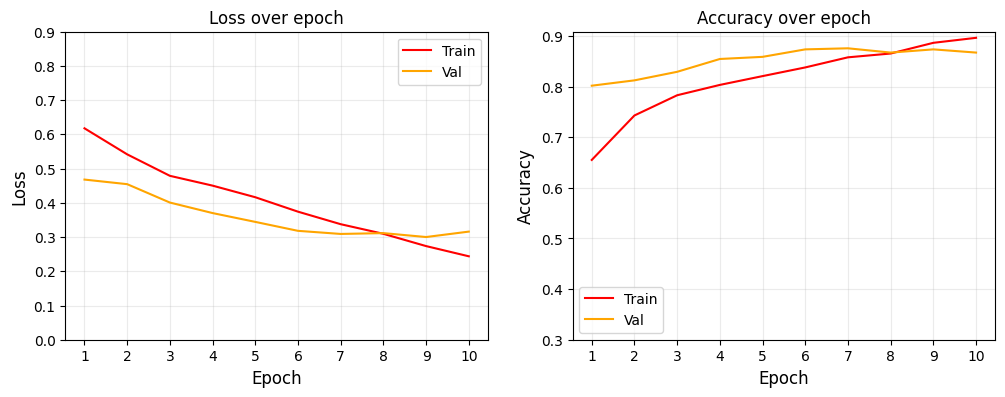

In [180]:
performance_plot(history3) # with dropout rate

In [181]:
model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,949 (2.01 MB)

 Trainable params: 175,649 (686.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 351,300 (1.34 MB)

### With learning rate = 0.0001, Dropout layer, with earlystopping

In [236]:
custom_seed_set()
model4 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling
    layers.Flatten(),  # Flatten to transition to fully connected layers
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary - class classification
])


model4.compile(optimizer=optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy']) # as default we have learning rate = 0.001
ES = EarlyStopping(monitor = 'val_accuracy', min_delta=1e-3, patience = 15, verbose = 1, restore_best_weights = False)

# Train the model
history4 = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[ES])  # Adjust epochs/batch size as needed

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5551 - loss: 0.6818 - val_accuracy: 0.7173 - val_loss: 0.5970
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7132 - loss: 0.5889 - val_accuracy: 0.7700 - val_loss: 0.5032
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7568 - loss: 0.5166 - val_accuracy: 0.7932 - val_loss: 0.4642
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7766 - loss: 0.4822 - val_accuracy: 0.8080 - val_loss: 0.4378
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7924 - loss: 0.4610 - val_accuracy: 0.8143 - val_loss: 0.4263
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7966 - loss: 0.4525 - val_accuracy: 0.8122 - val_loss: 0.4201
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7980 - loss: 0.4426 - val_accuracy: 0.8165 - val_loss: 0.4096
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8036 - loss: 0.4348 - val_accu

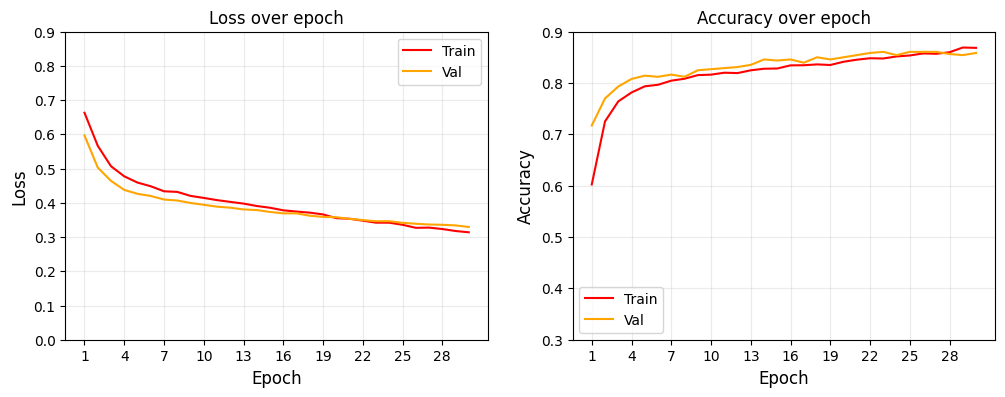

In [237]:
performance_plot(history4) # good model, good performance

### model with batch normalization and regularization: l2 = 0.001, learning rate = 0.0001

In [240]:
custom_seed_set()
model5 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling
    layers.Flatten(),  # Flatten to transition to fully connected layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Fully connected layer
    layers.Dropout(0.3),
    BatchNormalization(),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary - class classification
])


model5.compile(optimizer=optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history5 = model5.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[ES])  # Adjust epochs/batch size as needed

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5964 - loss: 0.7813 - val_accuracy: 0.7321 - val_loss: 0.7601
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7579 - loss: 0.6037 - val_accuracy: 0.8059 - val_loss: 0.6989
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7995 - loss: 0.5356 - val_accuracy: 0.8249 - val_loss: 0.6028
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8092 - loss: 0.5017 - val_accuracy: 0.8397 - val_loss: 0.5077
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8197 - loss: 0.4724 - val_accuracy: 0.8523 - val_loss: 0.4495
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8352 - loss: 0.4421 - val_accuracy: 0.8439 - val_loss: 0.4236
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8417 - loss: 0.4244 - val_accuracy: 0.8502 - val_loss: 0.4264
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8504 - loss: 0.4071 - val_accuracy: 0.854

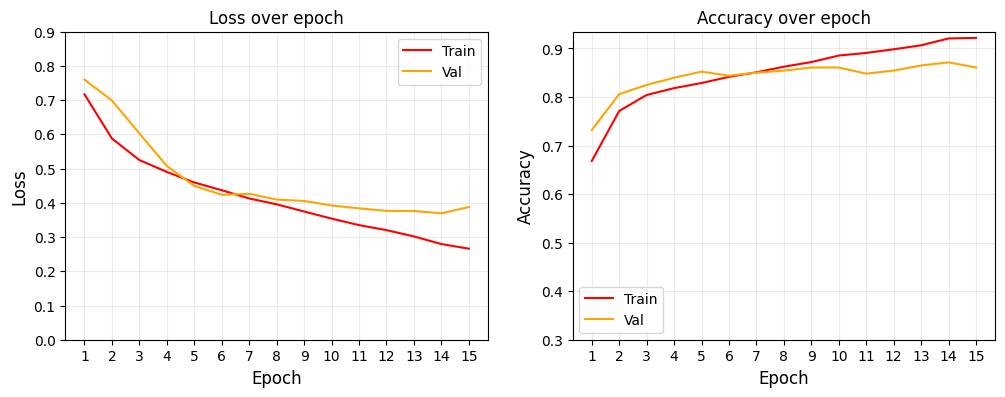

In [241]:
performance_plot(history5) # with batch normalization higher accuracy

### learning rate = 0.0001, kernel regularization 0.001, dropout rate = 0.6,BatchNormalization and Earlystopping

In [242]:
# learning rate = 0.0001, kernel regularization 0.001 
custom_seed_set()
model6 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling
    layers.Flatten(),  # Flatten to transition to fully connected layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Fully connected layer
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    BatchNormalization(),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary - class classification
])


model6.compile(optimizer=optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history6 = model6.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[ES])  # Adjust epochs/batch size as needed

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5471 - loss: 0.8594 - val_accuracy: 0.6814 - val_loss: 0.7808
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6983 - loss: 0.6853 - val_accuracy: 0.7595 - val_loss: 0.7334
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7466 - loss: 0.6146 - val_accuracy: 0.8186 - val_loss: 0.6802
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7638 - loss: 0.5681 - val_accuracy: 0.8249 - val_loss: 0.5735
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7942 - loss: 0.5402 - val_accuracy: 0.7911 - val_loss: 0.5510
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7933 - loss: 0.5184 - val_accuracy: 0.8481 - val_loss: 0.4621
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8193 - loss: 0.4859 - val_accuracy: 0.8544 - val_loss: 0.4520
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8213 - loss: 0.4656 - val_accu

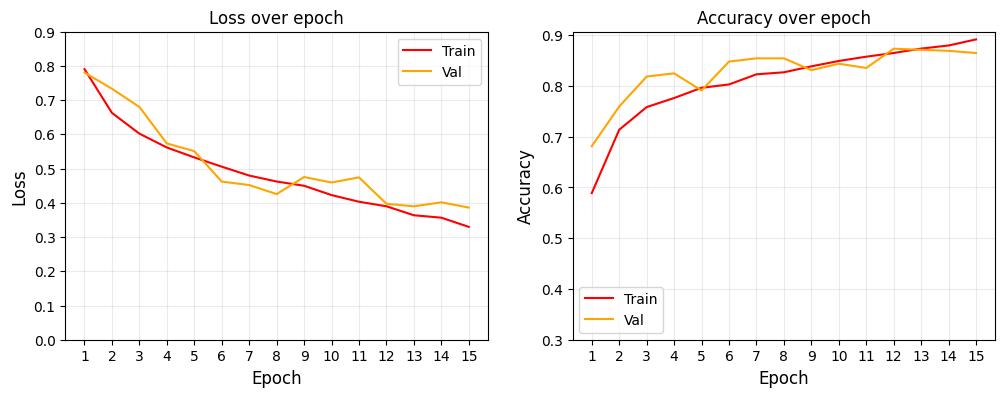

In [243]:
performance_plot(history6)

### Hyperparameter tuning 

In [188]:
# Define a model-building function with tunable hyperparameters
def build_model(hp):
    learning_rate=hp.Choice('lr', [0.0001, 0.0005, 0.001, 0.0002])
    dropout_rate=hp.Float('dropout', min_value=0.3, max_value = 0.7, step=0.1)
    l2_l = hp.Choice('l2_lambda', [0.01, 0.001, 0.0001])
    model = keras.Sequential()
    
    # First block of convolutional layers
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,1))),
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu')),
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu')),
    model.add(layers.MaxPooling2D((2, 2)))
     
    model.add(layers.Flatten())

    # Dense layer with tunable units (not filters)
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_l))),
    model.add(layers.Dropout(dropout_rate)),
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile with tunable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [212]:
import shutil

# Clear the tuner directory to start fresh
 # shutil.rmtree('kt_results', ignore_errors=True)  # Removes the entire directory

In [190]:
from keras_tuner import HyperParameters

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',  # Objective to maximize
    max_trials=15,  # Number of different configurations to try
    executions_per_trial=1,  # Number of times to execute each trial
    directory='kt_results',  # Directory to save results
    project_name='cnn_hyperparam_tuning'  # Project name
)


# Execute the hyperparameter search
tuner.search(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.1,
    batch_size=32,  # You can vary this with another hyperparameter
    callbacks=[]  # Add early stopping or other callbacks if needed
)

Reloading Tuner from kt_results/cnn_hyperparam_tuning/tuner0.json


In [191]:
tuner.results_summary()

Results summary
Results in kt_results/cnn_hyperparam_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
lr: 0.001
dropout: 0.5
l2_lambda: 0.001
Score: 0.8670886158943176

Trial 13 summary
Hyperparameters:
lr: 0.001
dropout: 0.5
l2_lambda: 0.01
Score: 0.8649789094924927

Trial 11 summary
Hyperparameters:
lr: 0.001
dropout: 0.6000000000000001
l2_lambda: 0.001
Score: 0.8628692030906677

Trial 10 summary
Hyperparameters:
lr: 0.001
dropout: 0.6000000000000001
l2_lambda: 0.0001
Score: 0.8586497902870178

Trial 14 summary
Hyperparameters:
lr: 0.001
dropout: 0.6000000000000001
l2_lambda: 0.01
Score: 0.8565400838851929

Trial 08 summary
Hyperparameters:
lr: 0.001
dropout: 0.4
l2_lambda: 0.001
Score: 0.8544303774833679

Trial 00 summary
Hyperparameters:
lr: 0.001
dropout: 0.4
l2_lambda: 0.0001
Score: 0.852320671081543

Trial 09 summary
Hyperparameters:
lr: 0.0002
dropout: 0.5
l2_lambda: 0.001
Score: 0.852320671081543

Trial 02 summary

In [192]:
custom_seed_set()
model_bb= Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling
    layers.Flatten(),  # Flatten to transition to fully connected layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Fully connected layer
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary - class classification
])


model_bb.compile(optimizer=optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_bb = model_bb.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[ES])  # Adjust epochs/batch size as needed

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5320 - loss: 0.7501 - val_accuracy: 0.7321 - val_loss: 0.5748
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7171 - loss: 0.6002 - val_accuracy: 0.7827 - val_loss: 0.4807
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7411 - loss: 0.5600 - val_accuracy: 0.7911 - val_loss: 0.4622
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7694 - loss: 0.5058 - val_accuracy: 0.8186 - val_loss: 0.4212
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7955 - loss: 0.4768 - val_accuracy: 0.8080 - val_loss: 0.4351
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8131 - loss: 0.4459 - val_accuracy: 0.8376 - val_loss: 0.3879
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8270 - loss: 0.4212 - val_accuracy: 0.8481 - val_loss: 0.3774
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8214 - loss: 0.4232 - val_accuracy: 0.854

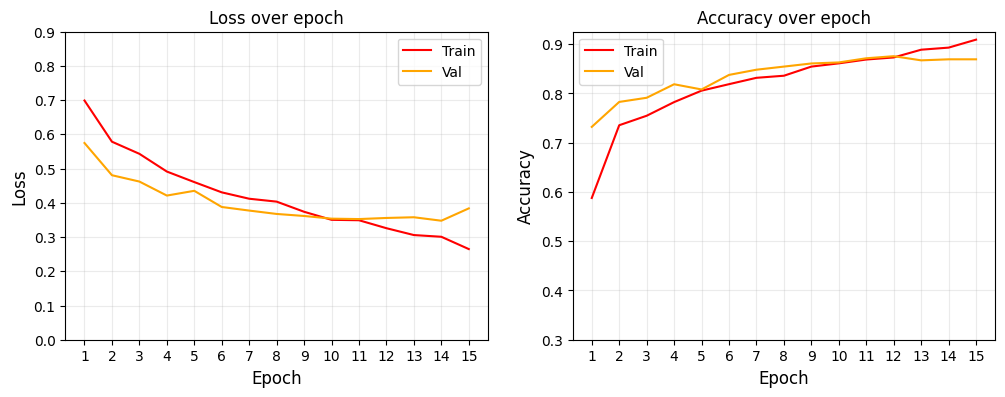

In [193]:
performance_plot(history_bb) # good model 

In [262]:
# save the model 
file_path0= 'my_model0.h5'
model_bb.save(file_path0, save_format='h5')
print(f"Model saved to {file_path0}")


Model saved to my_model0.h5


### Another architecture

In [195]:
# Define an L2 regularizer to prevent overfitting
l2_regularizer = regularizers.l2(0.001)
learn_r = 0.0005

# Build a deeper CNN architecture for binary classification
model_a = Sequential([
    # First block of convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Input shape for large images  
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Downsample with max pooling
    layers.Dropout(0.4),  # Dropout to prevent overfitting
    
    # Second block of convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Third block of convolutional layers
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Flattening layer and fully connected layers
    layers.Flatten(),  # Flatten for dense layers
    layers.Dense(64, activation='relu', kernel_regularizer=l2_regularizer),  # Fully connected layer
    layers.Dropout(0.6),  # High dropout for fully connected layer
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with optimizer, loss function, and metrics
model_a.compile(optimizer=optimizers.Adam(learn_r), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history_a = model_a.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[ES]) 

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.5151 - loss: 0.9122 - val_accuracy: 0.5401 - val_loss: 0.7674
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.6817 - loss: 0.6907 - val_accuracy: 0.5464 - val_loss: 0.7006
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.7654 - loss: 0.6006 - val_accuracy: 0.8312 - val_loss: 0.5316
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.7604 - loss: 0.5766 - val_accuracy: 0.8059 - val_loss: 0.4879
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7801 - loss: 0.5453 - val_accuracy: 0.8418 - val_loss: 0.4443
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7995 - loss: 0.4972 - val_accuracy: 0.8291 - val_loss: 0.4567
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.7538 - loss: 0.5540 - val_accuracy: 0.7110 - val_loss: 0.5628
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8063 - loss: 0.4872 - val_accurac

In [196]:
# Model summary to check the architecture
model_a.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,413 (4.78 MB)

 Trainable params: 417,761 (1.59 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 835,524 (3.19 MB)

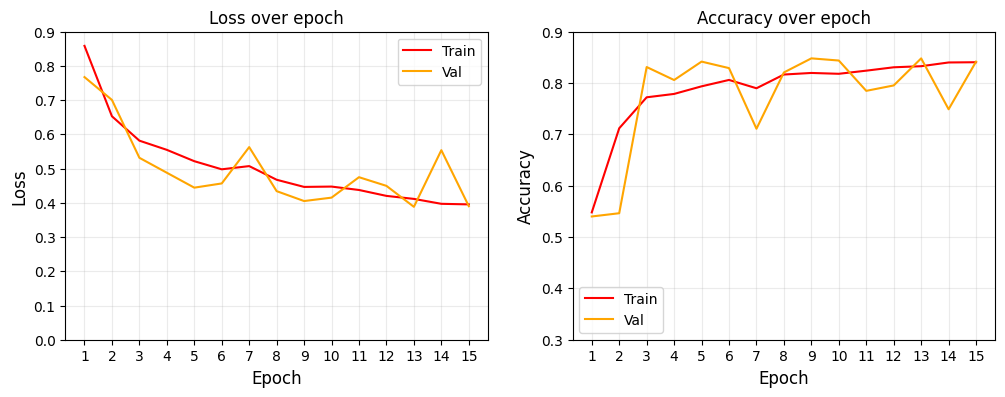

In [197]:
performance_plot(history_a)

In [198]:
# batch size = 64 how does the model perform ?
l2_regularizer = regularizers.l2(0.001)
learn_r = 0.0005

# Build a deeper CNN architecture for binary classification
model_ab = Sequential([
    # First block of convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Input shape for large images  
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Downsample with max pooling
    layers.Dropout(0.4),  # Dropout to prevent overfitting
    
    # Second block of convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Third block of convolutional layers
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Flattening layer and fully connected layers
    layers.Flatten(),  # Flatten for dense layers
    layers.Dense(64, activation='relu', kernel_regularizer=l2_regularizer),  # Fully connected layer
    layers.Dropout(0.6),  # High dropout for fully connected layer
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with optimizer, loss function, and metrics
model_ab.compile(optimizer=optimizers.Adam(learn_r), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history_ab = model_ab.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=True, callbacks=[ES]) 

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.4944 - loss: 0.9580 - val_accuracy: 0.5232 - val_loss: 0.7954
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.5333 - loss: 0.8449 - val_accuracy: 0.5232 - val_loss: 0.7815
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.6856 - loss: 0.7014 - val_accuracy: 0.6181 - val_loss: 0.7066
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.7559 - loss: 0.6113 - val_accuracy: 0.6498 - val_loss: 0.6468
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.7726 - loss: 0.5555 - val_accuracy: 0.8228 - val_loss: 0.5917
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.7971 - loss: 0.5343 - val_accuracy: 0.7468 - val_loss: 0.6058
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.8027 - loss: 0.5201 - val_accuracy: 0.8460 - val_loss: 0.4475
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.8021 - loss: 0.5103 - val_accuracy: 0.763

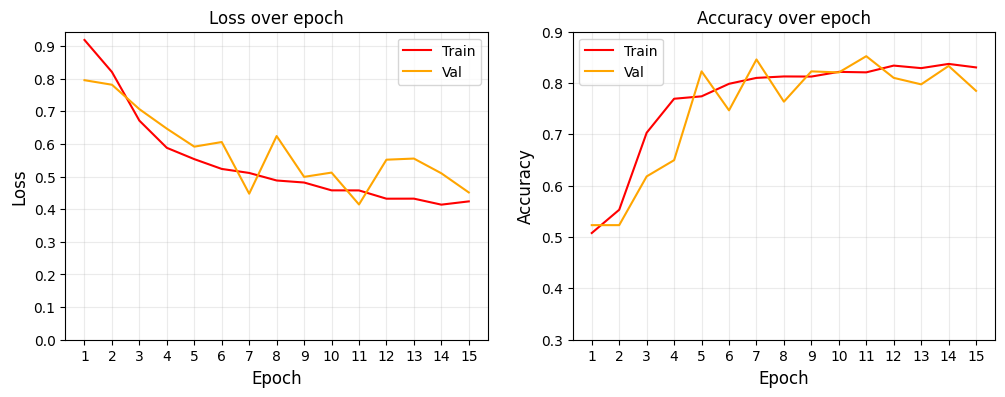

In [200]:
performance_plot(history_ab) # as we can see with batch size = 64, the model does not improve its performance.

### With some adjustments

In [201]:
# Define an L2 regularizer to prevent overfitting
l2_regularizer = regularizers.l2(0.0001)
learn_r = 0.0001

# Build a deeper CNN architecture for binary classification
model_be = Sequential([
    # First block of convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 1)),  # Input shape for large images
    layers.Conv2D(32, (3, 3), activation='relu',padding="same"),
    layers.MaxPooling2D((2, 2)),  # Downsample with max pooling
    layers.Dropout(0.4),  # Dropout to prevent overfitting
    
    # Second block of convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu',padding="same"),
    layers.Conv2D(64, (3, 3), activation='relu',padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Third block of convolutional layers
    layers.Conv2D(128, (3, 3), activation='relu',padding="same"),
    layers.Conv2D(128, (3, 3), activation='relu',padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Flattening layer and fully connected layers
    layers.Flatten(),  # Flatten for dense layers

    layers.Dense(128, activation='relu', kernel_regularizer=l2_regularizer), 
    layers.Dropout(0.6),  # High dropout for fully connected layer
    
    layers.Dense(64, activation='relu', kernel_regularizer=l2_regularizer), 

    layers.Dense(32, activation='relu', kernel_regularizer=l2_regularizer), 
    layers.BatchNormalization(), 

    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with optimizer, loss function, and metrics
model_be.compile(optimizer=optimizers.Adam(learn_r), loss='binary_crossentropy', metrics=['accuracy'])
history_be = model_be.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[ES]) 

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.4992 - loss: 0.8246 - val_accuracy: 0.4768 - val_loss: 0.7329
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.5115 - loss: 0.7416 - val_accuracy: 0.4768 - val_loss: 0.7333
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.5066 - loss: 0.7312 - val_accuracy: 0.4768 - val_loss: 0.7312
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.6285 - loss: 0.6780 - val_accuracy: 0.7743 - val_loss: 0.6079
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.7375 - loss: 0.5750 - val_accuracy: 0.7637 - val_loss: 0.5336
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.7572 - loss: 0.5443 - val_accuracy: 0.7911 - val_loss: 0.5377
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.7561 - loss: 0.5314 - val_accuracy: 0.7278 - val_loss: 0.6146
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.7733 - loss: 0.5183 - val

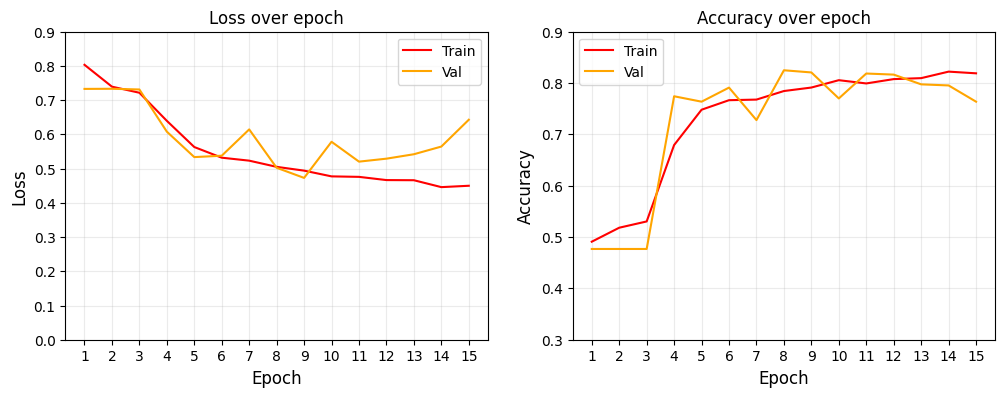

In [202]:
performance_plot(history_be) # the model is deeper but the performance is not improved a lot comparing it with the previous one.

### Hyperparameter tuning

In [225]:
# Define a model-building function with tunable hyperparameters
def build_model_a1(hp):
    hp_learning_rate=hp.Choice('lr', [0.0001, 0.0005, 0.001, 0.0002])
    hp_dropout_rate1=hp.Float('dropout_rate1', min_value=0.3, max_value = 0.5, step=0.1)
    hp_dropout_rate2=hp.Float('dropout_rate2', min_value=0.5, max_value = 0.7, step=0.1)


    hp_l2_l =hp.Choice('l2_l', [0.0001, 0.001, 0.01])
    model_a1 = keras.Sequential()
    
    # First block of convolutional layers
    model_a1.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(64,64,1))),
    model_a1.add(layers.MaxPooling2D((2, 2)))
    model_a1.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same')),
    model_a1.add(layers.MaxPooling2D((2, 2)))
    model_a1.add(layers.Dropout(hp_dropout_rate1))


    model_a1.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')),
    model_a1.add(layers.MaxPooling2D((2, 2)))
    model_a1.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')),
    model_a1.add(layers.MaxPooling2D((2, 2)))
    model_a1.add(layers.Dropout(hp_dropout_rate1))

    model_a1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')),
    model_a1.add(layers.MaxPooling2D((2, 2)))
    model_a1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')),
    model_a1.add(layers.MaxPooling2D((2, 2)))

    model_a1.add(layers.Dropout(hp_dropout_rate1))

    
    model_a1.add(layers.Flatten())

    # Dense layer with tunable units (not filters)
    model_a1.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(hp_l2_l))),
    model_a1.add(layers.Dropout(hp_dropout_rate2))
    model_a1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(hp_l2_l))),
    model_a1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(hp_l2_l))),
    model_a1.add(layers.BatchNormalization()),
    model_a1.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile with tunable learning rate
    model_a1.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model_a1


In [226]:
# Clear the tuner directory to start fresh
shutil.rmtree('tuning_results', ignore_errors=True)  # Removes the entire directory

In [227]:
# Define a tuner and search for optimal hyperparameters
tuner1 = kt.BayesianOptimization(
    build_model_a1,
    objective='val_accuracy',
    max_trials=15,
    directory='tuning_results',  # Directory to save results
    project_name='chihuahua_muffin_tuning'
)

In [228]:
# Execute tuning
tuner1.search(X_train, y_train, epochs=30, validation_split=0.1, batch_size=32)

Trial 15 Complete [00h 02m 10s]
val_accuracy: 0.8987341523170471

Best val_accuracy So Far: 0.9008438587188721
Total elapsed time: 03h 58m 54s


In [229]:
# Get the best hyperparameters and model
best_hps = tuner1.get_best_hyperparameters(num_trials=1)[0]
best_model_t = tuner1.get_best_models(num_models=1)[0]

# print("Best Hyperparameters:")
print(best_hps.values)


{'lr': 0.0002, 'dropout_rate1': 0.3, 'dropout_rate2': 0.5, 'l2_l': 0.0001}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [230]:
# Build a deeper CNN architecture for binary classification
model_bbb= Sequential([
    # First block of convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 1)),  # Input shape for large images
    layers.Conv2D(32, (3, 3), activation='relu',padding="same"),
    layers.MaxPooling2D((2, 2)),  # Downsample with max pooling
    layers.Dropout(0.3),  # Dropout to prevent overfitting
    
    # Second block of convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu',padding="same"),
    layers.Conv2D(64, (3, 3), activation='relu',padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Third block of convolutional layers
    layers.Conv2D(128, (3, 3), activation='relu',padding="same"),
    layers.Conv2D(128, (3, 3), activation='relu',padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Flattening layer and fully connected layers
    layers.Flatten(),  # Flatten for dense layers

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)), 
    layers.Dropout(0.5),  # High dropout for fully connected layer
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)), 

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)), 
    layers.BatchNormalization(), 

    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with optimizer, loss function, and metrics
model_bbb.compile(optimizer=optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
history_bbb = model_bbb.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[ES]) 

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.4973 - loss: 0.7536 - val_accuracy: 0.5232 - val_loss: 0.7223
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.6550 - loss: 0.6511 - val_accuracy: 0.6603 - val_loss: 0.6740
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.7490 - loss: 0.5513 - val_accuracy: 0.8059 - val_loss: 0.5600
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.7707 - loss: 0.5155 - val_accuracy: 0.7722 - val_loss: 0.5098
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.7885 - loss: 0.4887 - val_accuracy: 0.7046 - val_loss: 0.6758
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.8068 - loss: 0.4722 - val_accuracy: 0.7511 - val_loss: 0.5624
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.8265 - loss: 0.4451 - val_accuracy: 0.8418 - val_loss: 0.3989
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.8276 - loss: 0

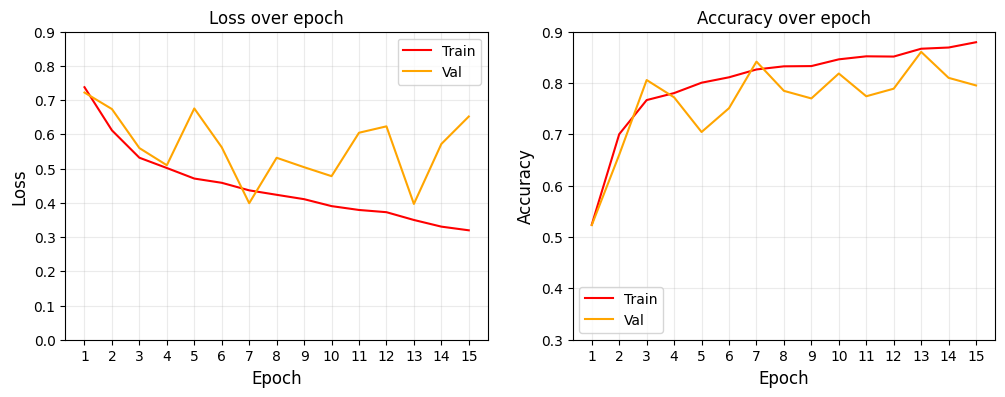

In [231]:
performance_plot(history_bbb)

### This architecture is deeper, but it does not perform well, it still have overfitting problem 

# Final model

### with the previous model

In [263]:
loaded_model0 = keras.models.load_model(file_path0)

print("Model loaded successfully")

Model loaded successfully


In [264]:
model_bb.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8415 - loss: 0.4616


[0.4187251329421997, 0.8572635054588318]

## 5-Fold cross validation 

In [221]:
# Initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Shuffle for better randomness

# List to store loss for each fold
accuracy_lists0 = [] # define an accuracy list
loss_lists0 = [] #  define a zero one loss list 
index = 1

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X_train):
    # Create training and test sets
    X_train_cv, X_val_cv= X_train[train_index], X_train[test_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[test_index]

    print(f"\nCycle number: {index}")
    
    # Clone the model structure and compile (to avoid training the same model repeatedly)
    model_f = keras.Sequential()
    
    # First block of convolutional layers
    model_f.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(64,64,1))),
    model_f.add(layers.MaxPooling2D((2, 2)))
    model_f.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same')),
    model_f.add(layers.MaxPooling2D((2, 2)))


    model_f.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')),
    model_f.add(layers.MaxPooling2D((2, 2)))
       
    model_f.add(layers.Flatten())

    # Dense layer with tunable units (not filters)
    model_f.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))),
    model_f.add(layers.Dropout(0.5))
    model_f.add(layers.Dense(1, activation='sigmoid'))
    model_f.compile(optimizer=optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    

    # Train the model
    model_f.fit(X_train_cv, y_train_cv, epochs=60, batch_size=32, validation_data=(X_val_cv,y_val_cv), shuffle =True, callbacks = [ES])  # Train on each fold

    loss, accuracy = model_f.evaluate(X_val_cv,y_val_cv)
    zero_one_loss0 = 1-accuracy
    loss_lists0.append(zero_one_loss0)
    accuracy_lists0.append(accuracy)

    index+=1

print("Zero-One Losses:", loss_lists0)
average_loss0 = np.mean(loss_lists0)
print("Average Zero-One Losses:", average_loss0)

print("Accuracies:", accuracy_lists0)
average_acc0 = np.mean(accuracy_lists0)
print("Average accuracies:", average_acc0)

# runnare questa parte 



Cycle number: 1
Epoch 1/60


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5701 - loss: 0.7365 - val_accuracy: 0.7307 - val_loss: 0.5817
Epoch 2/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7198 - loss: 0.5846 - val_accuracy: 0.7635 - val_loss: 0.5236
Epoch 3/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7662 - loss: 0.5263 - val_accuracy: 0.7603 - val_loss: 0.5142
Epoch 4/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7793 - loss: 0.5135 - val_accuracy: 0.7856 - val_loss: 0.4882
Epoch 5/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7879 - loss: 0.4962 - val_accuracy: 0.7888 - val_loss: 0.4707
Epoch 6/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8185 - loss: 0.4588 - val_accuracy: 0.8004 - val_loss: 0.4507
Epoch 7/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8315 - loss: 0.4316 - val_accuracy: 0.8163 - val_loss: 0.4389
Epoch 8/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8318 - loss: 0.4238 - val_accuracy: 0.821

### zero-one loss : 0.14
### average accuracy: 85,51%

## Confusion matrix

In [222]:
y_pre = loaded_model0.predict(X_test)
y_pre_label = np.round(y_pre).astype(int).reshape(-1)

incorrect_indexes=np.nonzero(y_pre_label != y_test)[0]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


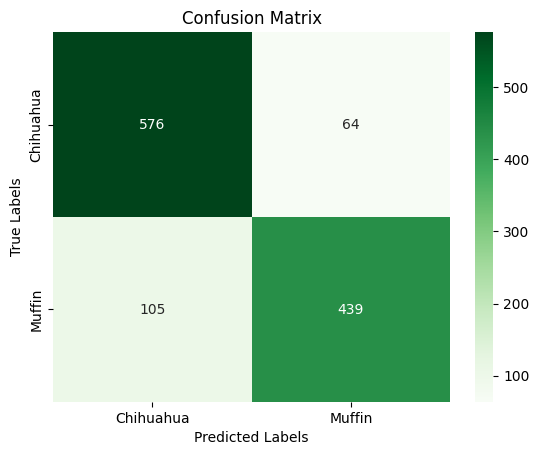

In [234]:
# Create the confusion matrix
cmf = confusion_matrix(y_test, y_pre_label)  # Build the confusion matrix

# Display the confusion matrix as a heatmap
sns.heatmap(cmf, annot=True, fmt='d', cmap='Greens', xticklabels=['Chihuahua', 'Muffin'], yticklabels=['Chihuahua', 'Muffin'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Some misclassified images

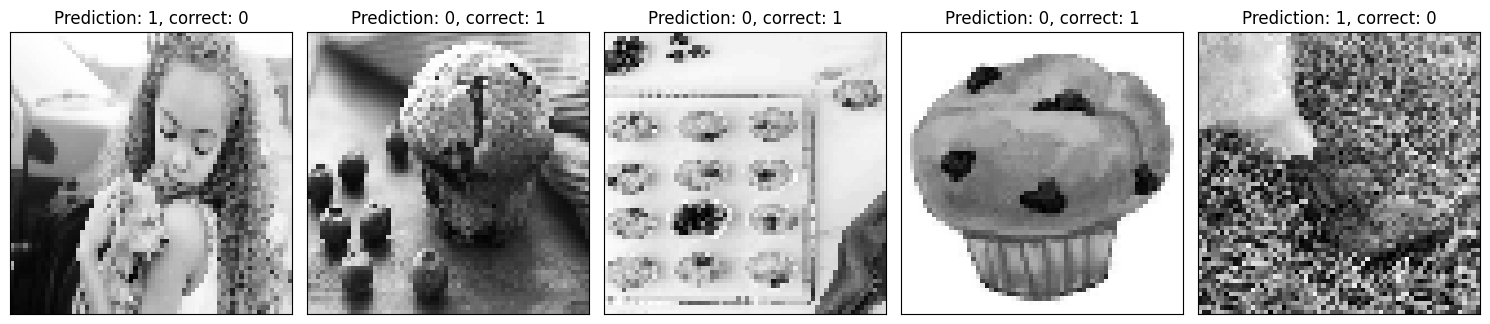

In [261]:
n_show = min(len(incorrect_indexes), 5)
fig,axes =plt.subplots(1, 5, figsize=(15, 4*n_show))
for i, incorrect_in in enumerate(incorrect_indexes[:n_show]):
    axes[i].imshow(X_test[incorrect_in], cmap='gray', interpolation='none')
    axes[i].set_title("Prediction: {}, correct: {}".format(y_pre_label[incorrect_in], y_test[incorrect_in]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.tight_layout()
plt.show()